In [1]:
import tensorflow as tf
import numpy as np
import ast
import cv2
import json
import network as net
import math
import collections
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.image import imread

C:\Users\JAEKYU\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def make_batch(img_path, anno_data, batch_size = 8):
    num_of_data = len(img_path)
    index = np.arange(0, num_of_data)
    np.random.shuffle(index)
    index = index[:batch_size]
    
    shuffled_img_data = [img_path[i] for i in index]
    shuffled_anno_data = [anno_data[j] for j in index]
    
    return np.asarray(shuffled_img_data), np.asarray(shuffled_anno_data)

def path_to_image(img_path, batch_size):
    #buffer 선언
    image_data = np.zeros((batch_size, 356, 356, 3), np.uint8)
    
    index = 0
    for img in (img_path):
        #buffer = cv2.imread(img)
        #buffer = cv2.resize(buffer, (526, 526))
        #image_data[index] = buffer
        #index = index + 1
        #buffer = cv2.resize(buffer, (526, 526))

        image_data[index] = cv2.imread(img)
        index = index + 1

    return image_data

def _put_heatmap_on_plane(heatmap, plane_idx, joint, sigma, height, width, stride):
    start = stride / 2.0 - 0.5

    center_x, center_y = joint

    for g_y in range(height):
        for g_x in range(width):
            x = start + g_x * stride
            y = start + g_y * stride
            d2 = (x-center_x) * (x-center_x) + (y-center_y) * (y-center_y)
            exponent = d2 / 2.0 / sigma / sigma
            if exponent > 4.6052:
                continue

            heatmap[g_y, g_x, plane_idx] += math.exp(-exponent)
            if heatmap[g_y, g_x, plane_idx] > 1.0:
                heatmap[g_y, g_x, plane_idx] = 1.0
                
                
def _put_paf_on_plane(vectormap, countmap, plane_idx, center_from, center_to, threshold, height, width, stride):
    center_from = (center_from[0] // stride, center_from[1] // stride)
    center_to = (center_to[0] // stride, center_to[1] // stride)

    vec_x = center_to[0] - center_from[0]
    vec_y = center_to[1] - center_from[1]

    min_x = max(0, int(min(center_from[0], center_to[0]) - threshold))
    min_y = max(0, int(min(center_from[1], center_to[1]) - threshold))

    max_x = min(width, int(max(center_from[0], center_to[0]) + threshold))
    max_y = min(height, int(max(center_from[1], center_to[1]) + threshold))

    norm = math.sqrt(vec_x ** 2 + vec_y ** 2)
    if norm < 1e-8: #1e-8 이하는 0으로 인식되서 0으로 나눌수 없다는 에러 발생. 따라서 return처리 해줌
        return

    vec_x /= norm
    vec_y /= norm
    
    for x in range(min_x, max_x):
        for y in range(min_y, max_y):
            bec_x = x - center_from[0]
            bec_y = y - center_from[1]
            dist = abs(bec_x * vec_y - bec_y * vec_x)

            if dist > threshold:
                continue

            countmap[x][y][plane_idx] = countmap[x][y][plane_idx] + 1

            vectormap[x][y][plane_idx*2+0] = vec_x
            vectormap[x][y][plane_idx*2+1] = vec_y
            

def bubble_sort(L):
    for i in range(len(L)-1):
        for j in range(len(L)-1):
            if L[j] > L[j+1]:
                temp = L[j+1]
                L[j+1] = L[j]
                L[j] = temp

In [3]:
class openpose():
    def __init__(self, batch_size):
        
        self.X = tf.placeholder(dtype=tf.float32, shape=[None, 356, 356, 3])
        self.confidence_map_label = tf.placeholder(dtype=tf.float32, shape=[None, 44, 44, 17])
        self.vector_map_label = tf.placeholder(dtype=tf.float32, shape=[None, 44, 44, 34])
        self.batch_size = batch_size
        print("data load start")
        self.image_path, self.annotation_data = self.load_data()
        print("data load finish")
        self.model()
        self.optimizer()
        print("open pose init complete")
        
        
    def load_data(self):
        path = "./MPII_Dataset/annotation/mpii_human_pose_v1_u12_3.json"
        f = open(path)
        print("hello")
        s = f.readlines()

        file_name = []
        parts = []
        _joint_data = []
        
        
        img_path = "./MPII_Dataset/images/"#######
        img_path2 = "./MPII_Dataset/resized_images2/"
        file_path = []
        file_path2 = []

        for index, i in enumerate(s):

            file_name_index = i.find("file_name")
            is_train_index = i.find("is_train")
            file_name.append(i[file_name_index + 13 :is_train_index - 4])


            parts_index = i.find("parts")
            visibility_index = i.find("visibility")
            parts.append(i[parts_index + 8:visibility_index - 3])

            joint_data = []
            file_index, annotation_index = index, index
            if(parts[index] == "null"):
                joint_data.append("null")
                pass
            else:
                raw_data = ast.literal_eval(parts[annotation_index])
                joint_data.append(raw_data)

            _joint_data.append(joint_data)
            index = index + 1
        for i in file_name:
            file_path.append(img_path + i)############
            file_path2.append(img_path2 + i)

        index2 = 0
        heatmap_height = 44
        heatmap_width = 44
        for j in file_path:
            img_data = cv2.imread(j)
            height = (np.shape(img_data)[0])
            width = (np.shape(img_data)[1])

            if(_joint_data[index2][0] == 'null'):
                #print(_joint_data[index2][0])
                pass
            else:
                array = _joint_data[index2][0].keys()
                for k in array:
                    _joint_data[index2][0][k][0] = int(_joint_data[index2][0][k][0] / height * heatmap_height)
                    _joint_data[index2][0][k][1] = int(_joint_data[index2][0][k][1] / width * heatmap_width)



            index2 = index2 + 1

        
        return file_path2, _joint_data
    
    def make_heatmap(self, batch_anno_data, width = 44, height = 44, num_of_maps = 17):
        batch_size = self.batch_size
        width = 44
        height = 44
        num_of_maps = 17
        output = np.zeros((batch_size, width, height, num_of_maps))
        for index, joint_data in enumerate(batch_anno_data):

            heatmap = np.zeros((width, height, num_of_maps), np.int16)#batch 일단 뺌

            for joints in joint_data:
                buffer = list(joints.items())
                key_buffer = joints.keys()

                for i in range(len(buffer)):
                    buffer[i] = list(buffer[i])
                    buffer[i][0] = int(buffer[i][0])
                bubble_sort(buffer)

                idx = 0
                for j in range(17):

                    #print(j)
                    if('%d' %j in key_buffer):
                        center_x = buffer[idx][1][0]
                        center_y = buffer[idx][1][1]
                        #joint = buffer[idx][1]
                        joint = [center_y, center_x]
                        idx = idx + 1
                        _put_heatmap_on_plane(heatmap, plane_idx = j, joint = joint, sigma = 3, height = height, \
                                              width = width, stride = 1)
                    else:
                        pass
                idx = 0
            heatmap[:, :, -1] = np.clip(1.0 - np.amax(heatmap, axis=2), 0.0, 1.0)
            output[index] = heatmap
        return output
        
    
    def make_paf_field(self, batch_joint_data, width = 44, height = 44, num_of_maps = 17):
        batch_size = 8
        output1 = np.zeros((batch_size, width, height, num_of_maps*2))
        output2 = np.zeros((batch_size, width, height, num_of_maps))
        for index, joint_data in enumerate(batch_joint_data):
            joint_pairs = list(zip(
                [9, 8, 8, 8,13,14,12,11,7,6,6,3,4,2,1],
                [8,13,12, 7,14,15,11,10,6,3,2,4,5,1,0]))
            #make vector map
            width = 44
            height = 44
            num_of_maps = 17
            vectormap = np.zeros((width, height, num_of_maps*2), dtype=np.float32)#batch 일단 뺌
            countmap = np.zeros((width, height, num_of_maps), np.int16)#batch 일단 뺌

            for joints in joint_data:
                key = (joints.keys())
                for plane_idx, (j_idx1, j_idx2) in enumerate(joint_pairs):
                    if(('%d' %j_idx1 in key) and ('%d' %j_idx2 in key)):

                        center_from = joints['%d'%j_idx1]
                        center_to = joints['%d'%j_idx2]

                        if not center_from or not center_to:
                            continue
                        _put_paf_on_plane(vectormap=vectormap, countmap=countmap, plane_idx=plane_idx, center_from=center_from, center_to=center_to, \
                                          threshold=1, height=44, width=44, stride = 1)

            nonzeros = np.nonzero(countmap)


            for x, y, p in zip(nonzeros[0], nonzeros[1], nonzeros[2]):
                if countmap[x][y][p] <= 0:
                    continue
                vectormap[x][y][p*2+0] /= countmap[x][y][p]
                vectormap[x][y][p*2+1] /= countmap[x][y][p]

            output1[index] = vectormap.astype(np.float32)
            output2[index] = countmap
        return output1, output2 #output1 -> vectormap, output2 -> countmap


        
    
    def model(self):
        stage0_data = net.block_vgg_19(self.X)#stage0_data - None, 58, 58, 512
        
        self.stage1_branch1 = net.block_stage_1_branch1(stage0_data)#stage1_branch1 - None, 58, 58, 34
        self.stage1_branch2 = net.block_stage_1_branch2(stage0_data)#stage1_branch2 - None, 58, 58, 17
        self.stage1_data = tf.concat([self.stage1_branch1, self.stage1_branch2, stage0_data], 3)
        
        self.stage2_branch1 = net.block_stage_2_branch1(self.stage1_data)#stage2_branch1 - None, 58, 58, 34
        self.stage2_branch2 = net.block_stage_2_branch2(self.stage1_data)#stage2_branch2 - None, 58, 58, 17
        self.stage2_data = tf.concat([self.stage2_branch1, self.stage2_branch2, stage0_data], 3)

        self.stage3_branch1 = net.block_stage_3_branch1(self.stage2_data)#stage2_branch1 - None, 58, 58, 34
        self.stage3_branch2 = net.block_stage_3_branch2(self.stage2_data)#stage2_branch2 - None, 58, 58, 17
        self.stage3_data = tf.concat([self.stage3_branch1, self.stage3_branch2, stage0_data], 3)
        
        self.stage4_branch1 = net.block_stage_4_branch1(self.stage3_data)#stage2_branch1 - None, 58, 58, 34
        self.stage4_branch2 = net.block_stage_4_branch2(self.stage3_data)#stage2_branch2 - None, 58, 58, 17
        self.stage4_data = tf.concat([self.stage4_branch1, self.stage4_branch2, stage0_data], 3)
        
        self.stage5_branch1 = net.block_stage_5_branch1(self.stage4_data)#stage2_branch1 - None, 58, 58, 34
        self.stage5_branch2 = net.block_stage_5_branch2(self.stage4_data)#stage2_branch2 - None, 58, 58, 17
        self.stage5_data = tf.concat([self.stage5_branch1, self.stage5_branch2, stage0_data], 3)
        
        self.stage6_branch1 = net.block_stage_6_branch1(self.stage5_data)#stage2_branch1 - None, 58, 58, 34
        self.stage6_branch2 = net.block_stage_6_branch2(self.stage5_data)#stage2_branch2 - None, 58, 58, 17
        self.stage6_data = tf.concat([self.stage6_branch1, self.stage6_branch2, stage0_data], 3)

    def optimizer(self):
        
        W_p = 1
        #loss는 euclid loss 함수 사용
        #affinity field loss - branch1
        self.loss_stage1_branch1 = tf.nn.l2_loss(W_p*(self.stage1_branch1 - self.vector_map_label)) / self.batch_size
        self.loss_stage2_branch1 = tf.nn.l2_loss(W_p*(self.stage2_branch1 - self.vector_map_label)) / self.batch_size
        self.loss_stage3_branch1 = tf.nn.l2_loss(W_p*(self.stage3_branch1 - self.vector_map_label)) / self.batch_size
        self.loss_stage4_branch1 = tf.nn.l2_loss(W_p*(self.stage4_branch1 - self.vector_map_label)) / self.batch_size
        self.loss_stage5_branch1 = tf.nn.l2_loss(W_p*(self.stage5_branch1 - self.vector_map_label)) / self.batch_size
        self.loss_stage6_branch1 = tf.nn.l2_loss(W_p*(self.stage6_branch1 - self.vector_map_label)) / self.batch_size
        
        #self.optimizer_stage1_branch1 = tf.train.AdamOptimizer(learning_rate=1e-6).minimize(self.loss_stage1_branch1)
        #self.optimizer_stage2_branch1 = tf.train.AdamOptimizer(learning_rate=1e-6).minimize(self.loss_stage2_branch1)
        #self.optimizer_stage3_branch1 = tf.train.AdamOptimizer(learning_rate=1e-6).minimize(self.loss_stage3_branch1)
        #self.optimizer_stage4_branch1 = tf.train.AdamOptimizer(learning_rate=1e-6).minimize(self.loss_stage4_branch1)
        #self.optimizer_stage5_branch1 = tf.train.AdamOptimizer(learning_rate=1e-6).minimize(self.loss_stage5_branch1)
        #self.optimizer_stage6_branch1 = tf.train.AdamOptimizer(learning_rate=1e-6).minimize(self.loss_stage6_branch1)
        
        #confidence map loss - branch2
        
        self.loss_stage1_branch2 = tf.nn.l2_loss(W_p*(self.stage1_branch2 - self.confidence_map_label)) / self.batch_size
        self.loss_stage2_branch2 = tf.nn.l2_loss(W_p*(self.stage2_branch2 - self.confidence_map_label)) / self.batch_size
        self.loss_stage3_branch2 = tf.nn.l2_loss(W_p*(self.stage3_branch2 - self.confidence_map_label)) / self.batch_size
        self.loss_stage4_branch2 = tf.nn.l2_loss(W_p*(self.stage4_branch2 - self.confidence_map_label)) / self.batch_size
        self.loss_stage5_branch2 = tf.nn.l2_loss(W_p*(self.stage5_branch2 - self.confidence_map_label)) / self.batch_size
        self.loss_stage6_branch2 = tf.nn.l2_loss(W_p*(self.stage6_branch2 - self.confidence_map_label)) / self.batch_size
        
        #self.optimizer_stage1_branch2 = tf.train.AdamOptimizer(learning_rate=1e-6).minimize(self.loss_stage1_branch2)
        #self.optimizer_stage2_branch2 = tf.train.AdamOptimizer(learning_rate=1e-6).minimize(self.loss_stage2_branch2)
        #self.optimizer_stage3_branch2 = tf.train.AdamOptimizer(learning_rate=1e-6).minimize(self.loss_stage3_branch2)
        #self.optimizer_stage4_branch2 = tf.train.AdamOptimizer(learning_rate=1e-6).minimize(self.loss_stage4_branch2)
        #self.optimizer_stage5_branch2 = tf.train.AdamOptimizer(learning_rate=1e-6).minimize(self.loss_stage5_branch2)
        #self.optimizer_stage6_branch2 = tf.train.AdamOptimizer(learning_rate=1e-6).minimize(self.loss_stage6_branch2)
        
        self.loss1 = tf.reduce_mean([self.loss_stage1_branch1, self.loss_stage1_branch2])
        self.loss2 = tf.reduce_mean([self.loss_stage2_branch1, self.loss_stage2_branch2])
        self.loss3 = tf.reduce_mean([self.loss_stage3_branch1, self.loss_stage3_branch2])
        self.loss4 = tf.reduce_mean([self.loss_stage4_branch1, self.loss_stage4_branch2])
        self.loss5 = tf.reduce_mean([self.loss_stage5_branch1, self.loss_stage5_branch2])
        self.loss6 = tf.reduce_mean([self.loss_stage6_branch1, self.loss_stage6_branch2])
        
        self.total_loss = (self.loss1 + self.loss2 + self.loss3 + self.loss4 + self.loss5 + self.loss6) / self.batch_size
        
        global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 4e-5
        lr = tf.train.exponential_decay(starter_learning_rate, global_step,100000, 0.333, staircase=True)
        self.optimizer_total_loss = tf.train.AdamOptimizer(learning_rate=lr).minimize(self.total_loss, global_step=global_step)
        

    def train(self):
        data_size = 28883#41749
        batch_size = self.batch_size
        total_batch = data_size//batch_size

        h_loss_data = []
        #h_loss_data2 = []
        #h_loss_data3 = []
        #h_loss_data4 = []
        #h_loss_data5 = []
        #h_loss_data6 = []
        
        v_loss_data = []
        #v_loss_data2 = []
        #v_loss_data3 = []
        #v_loss_data4 = []
        #v_loss_data5 = []
        #v_loss_data6 = []
        
        SAVE_PATH = "C:/Users/JAEKYU/Documents/Jupyter Notebook/Open_Pose/Weight/Weight.ckpt"
        print("session start")
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            saver = tf.train.Saver()
            try:
                saver.restore(sess, SAVE_PATH)
                print("load")
            except:
                print("first training")
            

            for epoch in range(4):#15
                print("epoch",epoch+1, "start")
                for i in range(total_batch):#total_batch
                    #data load, batch 생성
                    batch_img_path, batch_annotation= make_batch(img_path = self.image_path, anno_data = self.annotation_data, batch_size = batch_size)
                    batch_img = path_to_image(batch_img_path, batch_size)
                    
                    #batch_img, batch_annotation - input data
                    
                    heatmap = self.make_heatmap(batch_annotation, width=44, height=44, num_of_maps=17)
                    vectormap, countmap = self.make_paf_field(batch_annotation, width = 44, height = 44, num_of_maps = 17)
                    
                    total_loss_opt, Heat_loss, Vector_loss = \
                    sess.run([self.optimizer_total_loss, self.loss_stage6_branch1, self.loss_stage6_branch2],
                             feed_dict = {self.X : batch_img, self.confidence_map_label : heatmap, self.vector_map_label : vectormap})
                    
                    
                    #__1, __2, __3, __4, __5, __6, v_cost1, v_cost2, v_cost3, v_cost4, v_cost5, v_cost6 = \
                    #sess.run([self.optimizer_stage1_branch1, self.optimizer_stage2_branch1, self.optimizer_stage3_branch1, \
                    #          self.optimizer_stage4_branch1, self.optimizer_stage5_branch1, self.optimizer_stage6_branch1, \
                    #          self.loss_stage1_branch1, self.loss_stage2_branch1, self.loss_stage3_branch1, \
                    #          self.loss_stage4_branch1, self.loss_stage5_branch1, self.loss_stage6_branch1], \
                    #         feed_dict = {self.X : batch_img, self.vector_map_label : vectormap})
                    
                    #_, cost, stage_output = sess.run([self.optimizer_stage1_branch2, self.loss_stage1_branch2, self.stage1_branch2], feed_dict = {self.X : batch_img, self.confidence_map_label : heatmap})
                    #session 돌리는 부분, run(optimizer)
                    #print("1 end")
                    h_loss_data.append(Heat_loss)
                    #h_loss_data2.append(h_cost2)
                    #h_loss_data3.append(h_cost3)
                    #h_loss_data4.append(h_cost4)
                    #h_loss_data5.append(h_cost5)
                    #h_loss_data6.append(h_cost6)
                    #print("2 end")
                    v_loss_data.append(Vector_loss)
                    #v_loss_data2.append(v_cost2)
                    #v_loss_data3.append(v_cost3)
                    #v_loss_data4.append(v_cost4)
                    #v_loss_data5.append(v_cost5)
                    #v_loss_data6.append(v_cost6)                    
                    #print("3 end")
                    #print("iteration end")
                print("heatmap cost")
                print("Heat_loss : ", Heat_loss)
                print("vectormap cost")
                print("Vector_loss : ", Vector_loss)
                print('\n')
                    
                    

                plt.plot(h_loss_data)
                plt.show()
                plt.plot(v_loss_data)
                plt.show()
                saver.save(sess, SAVE_PATH)
        #return batch_img, batch_img_path, batch_annotation, heatmap, vectormap, countmap
        #return self.image_path, self.annotation_data

        
    def load_test_data(self):
        file_name = []        

        img_path = "./MPII_Dataset/resized_images2/"
        file_path = []


        
    def test(self):
        batch_size = self.batch_size

        SAVE_PATH = "C:/Users/JAEKYU/Documents/Jupyter Notebook/Open_Pose/Weight/Weight.ckpt"
        print("session start")
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            saver = tf.train.Saver()
            
            saver.restore(sess, SAVE_PATH)
            print("load")
            

            batch_img_path, batch_annotation= make_batch(img_path = self.image_path, anno_data = self.annotation_data, batch_size = 8)
            batch_img = path_to_image(batch_img_path, batch_size)
            #batch_img, batch_annotation - input data

            heatmap = self.make_heatmap(batch_annotation, width=44, height=44, num_of_maps=17)
            vectormap, countmap = self.make_paf_field(batch_annotation, width = 44, height = 44, num_of_maps = 17)
            stage_output1, stage_output2, stage_output3, stage_output4, stage_output5, stage_output6 = sess.run([self.stage1_branch2, self.stage2_branch2, self.stage3_branch2, self.stage4_branch2, self.stage5_branch2, self.stage6_branch2], feed_dict = {self.X : batch_img, self.confidence_map_label : heatmap})
            _stage_output1, _stage_output2, _stage_output3, _stage_output4, _stage_output5, _stage_output6 = \
            sess.run([self.stage1_branch1, self.stage2_branch1, self.stage3_branch1, self.stage4_branch1, self.stage5_branch1, self.stage6_branch1], \
                     feed_dict = {self.X : batch_img, self.vector_map_label : vectormap})
        
        return batch_img, batch_img_path, batch_annotation, heatmap, stage_output4, stage_output5, stage_output6, _stage_output4, _stage_output5, _stage_output6
print("cell end")

cell end


In [4]:
obj = openpose(batch_size=8)

data load start
hello
data load finish
open pose init complete


session start
INFO:tensorflow:Restoring parameters from C:/Users/JAEKYU/Documents/Jupyter Notebook/Open_Pose/Weight/Weight.ckpt
first training
epoch 1 start
heatmap cost
Heat_loss :  80.96402
vectormap cost
Vector_loss :  14.633502




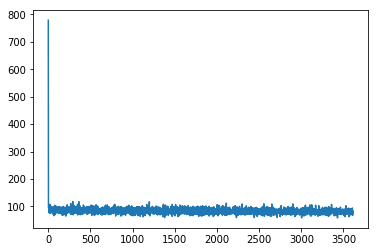

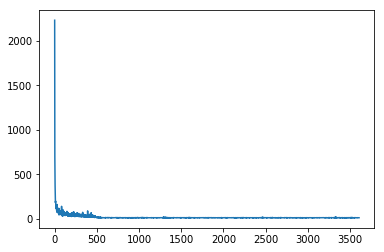

epoch 2 start
heatmap cost
Heat_loss :  75.888176
vectormap cost
Vector_loss :  15.106907




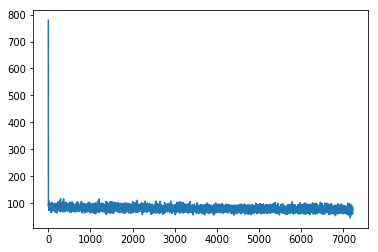

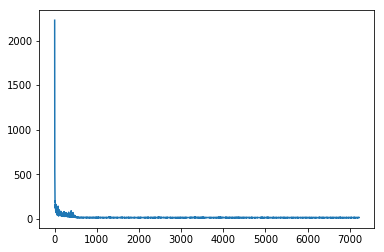

epoch 3 start
heatmap cost
Heat_loss :  72.77738
vectormap cost
Vector_loss :  12.962847




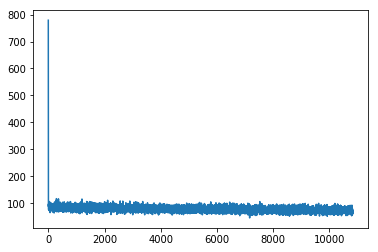

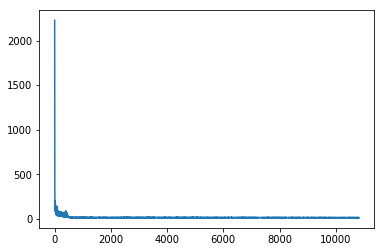

epoch 4 start
heatmap cost
Heat_loss :  66.175385
vectormap cost
Vector_loss :  13.619618




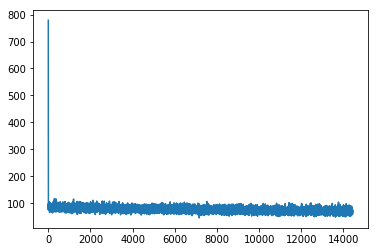

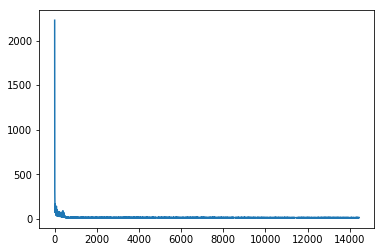

In [5]:
#batch_img, batch_img_path, batch_annotation, heatmap, vectormap, countmap = obj.train()
obj.train()

In [6]:
batch_img, batch_img_path, batch_annotation, heatmap, \
stage_output4, stage_output5, stage_output6, _stage_output4, _stage_output5, _stage_output6 = obj.test()

session start
INFO:tensorflow:Restoring parameters from C:/Users/JAEKYU/Documents/Jupyter Notebook/Open_Pose/Weight/Weight.ckpt
load


(8, 356, 356, 3)


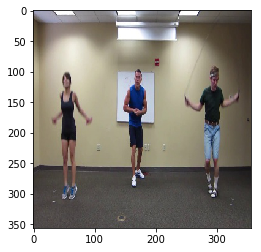

In [16]:
print(np.shape(batch_img))
test_index = 6
buffer = batch_img[test_index][:,:,[2,1,0]]
plt.imshow(buffer)
plt.show()

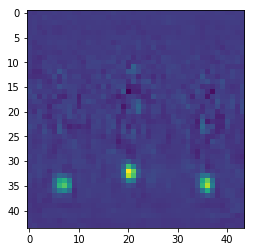

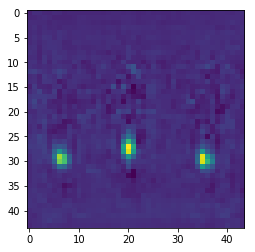

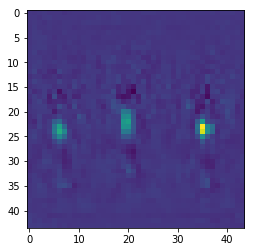

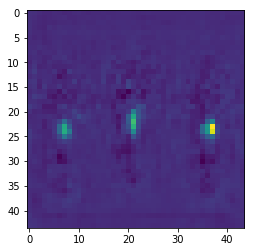

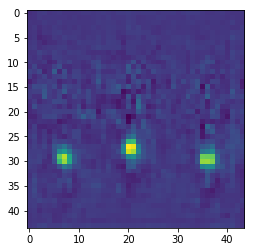

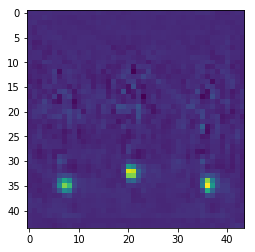

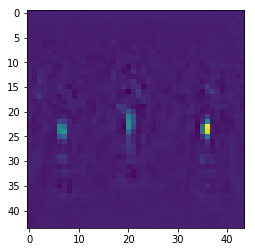

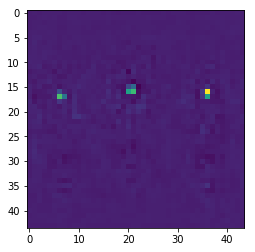

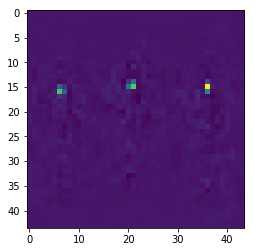

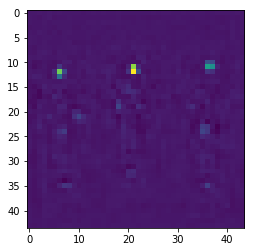

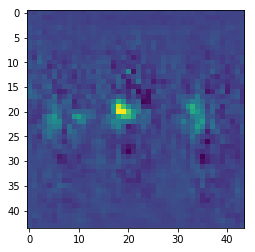

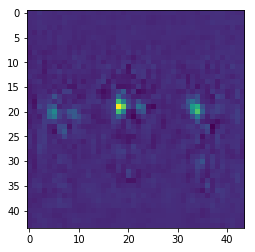

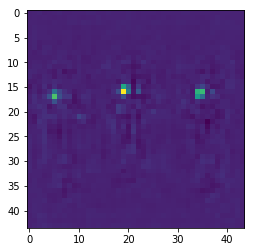

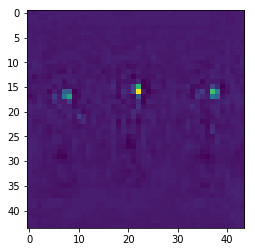

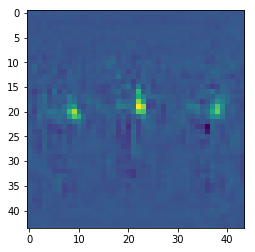

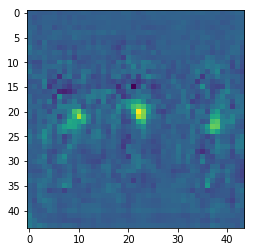

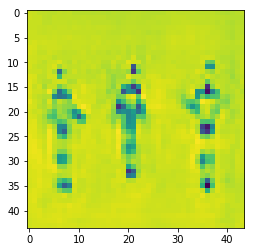

summed_heatmap


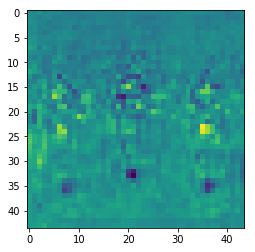

(44, 44)


array([[0.99402505, 0.99402505, 0.99402505, ..., 0.99246302, 0.99246302,
        0.99246302],
       [0.99402505, 0.99402505, 0.99402505, ..., 0.99246302, 0.99246302,
        0.99246302],
       [0.99402505, 0.99402505, 0.99402505, ..., 0.99246302, 0.99246302,
        0.99246302],
       ...,
       [0.99899829, 0.99899829, 0.99899829, ..., 0.9940355 , 0.9940355 ,
        0.9940355 ],
       [0.99899829, 0.99899829, 0.99899829, ..., 0.9940355 , 0.9940355 ,
        0.9940355 ],
       [0.99899829, 0.99899829, 0.99899829, ..., 0.9940355 , 0.9940355 ,
        0.9940355 ]])

In [17]:
#heatmap
np.shape(stage_output6)
buffer = stage_output6[test_index]
buffer = np.transpose(buffer, (2,0, 1))
#resized_buffer = np.zeros((17, 356, 356))
summed_buffer = np.zeros((44, 44))
for i in range(17):
    #resized_buffer[i] = cv2.resize(buffer[i], (356, 356))
    plt.imshow(buffer[i])
    plt.show()
    
#for i in range(17):
#    for row in range(44):
#        for col in range(44):
#            if(buffer[i][row][col] < 0.7):
#                buffer[i][row][col] = 0
for i in range(17):
    summed_buffer = summed_buffer + buffer[i]
#summed_buffer = summed_buffer * 100
print("summed_heatmap")
plt.imshow(summed_buffer)
plt.show()
summed_buffer
print(np.shape(summed_buffer))
#for row in range(44):
#    for col in range(44):
#        if(summed_buffer[row][col] < 1.0):
#            summed_buffer[row][col] = 0
summed_buffer = cv2.resize(summed_buffer, (356,356))
summed_buffer
cv2.imshow("image1",summed_buffer)
cv2.waitKey(0)
cv2.destroyAllWindows()
summed_buffer

(34, 44, 44)


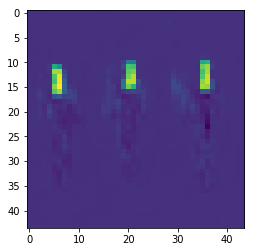

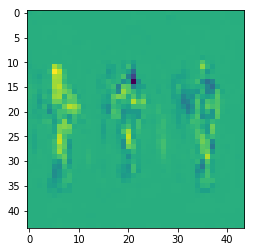

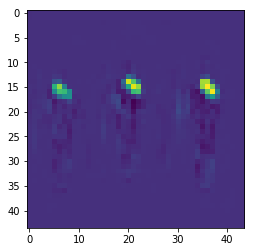

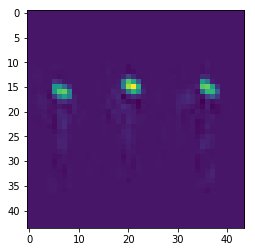

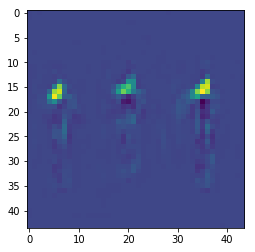

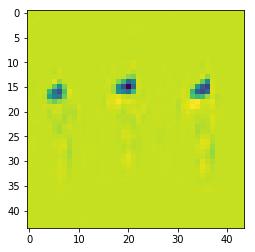

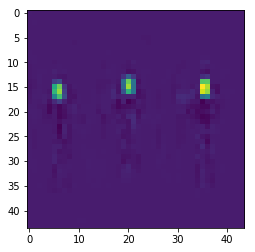

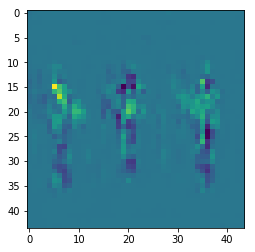

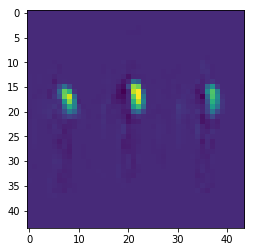

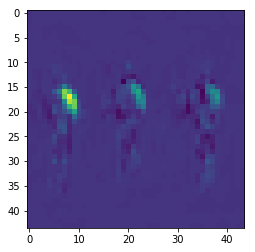

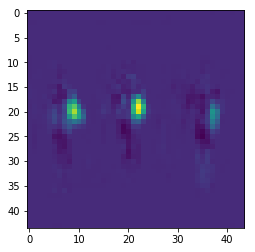

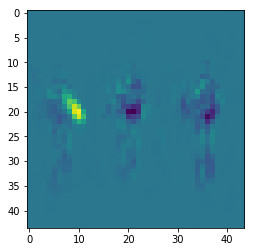

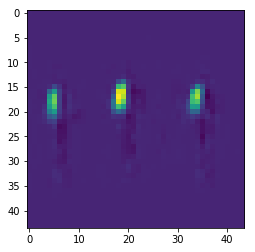

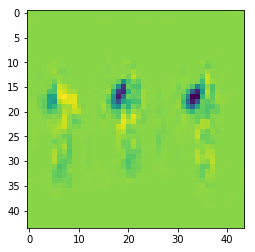

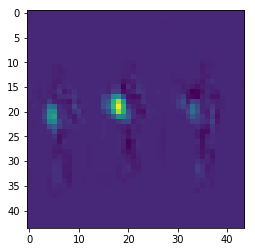

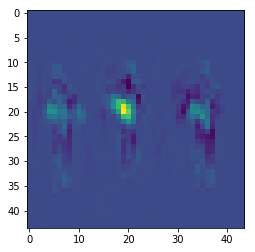

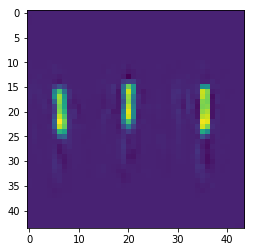

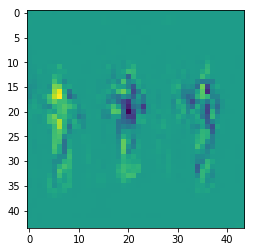

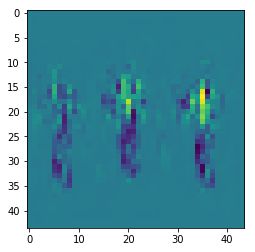

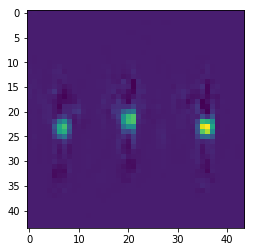

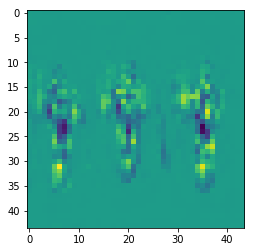

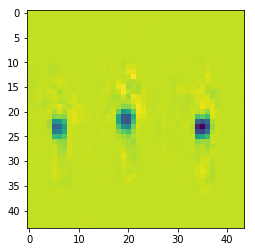

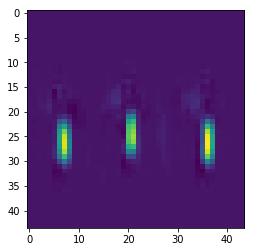

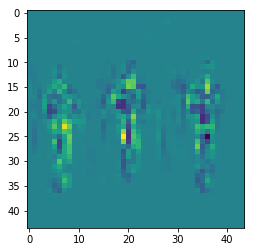

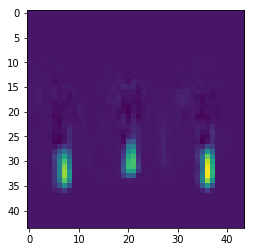

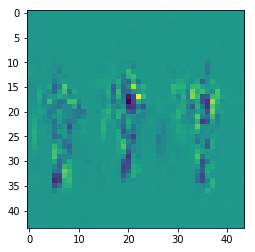

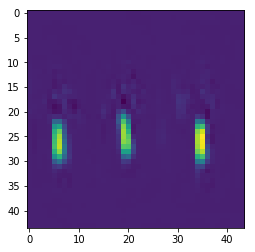

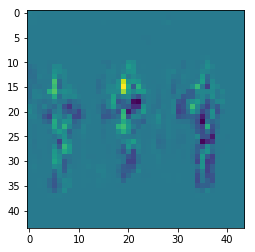

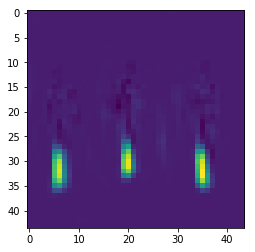

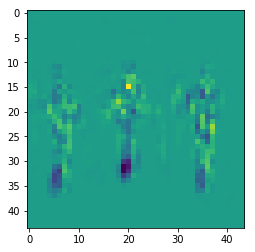

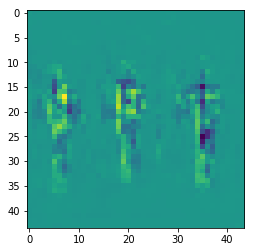

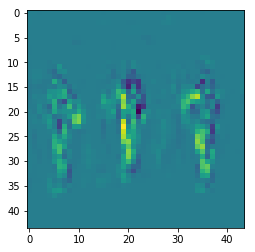

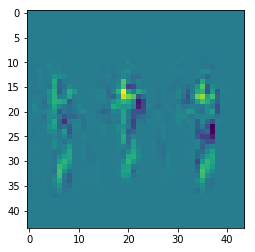

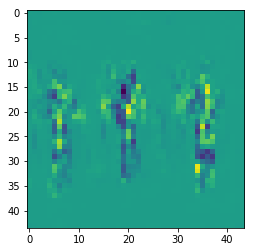

summed vectormap


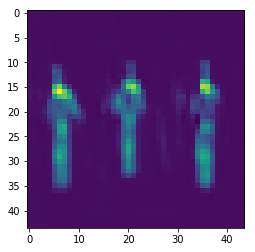

In [ ]:
#vectormap
np.shape(_stage_output6)
buffer = _stage_output6[test_index]
buffer = np.transpose(buffer, (2,0, 1))
print(np.shape(buffer))
#resized_buffer = np.zeros((34, 356, 356))
summed_buffer = np.zeros((44, 44))
for i in range(34):
    #resized_buffer[i] = cv2.resize(buffer[i], (356, 356))
    plt.imshow(buffer[i])
    plt.show()
#for i in range(34):
#    for row in range(44):
#        for col in range(44):
#            if(buffer[i][row][col] < 0.5):
#                buffer[i][row][col] = 0
for i in range(34):
    summed_buffer = summed_buffer + buffer[i]
print("summed vectormap")
plt.imshow(summed_buffer)
plt.show()

summed_buffer = cv2.resize(summed_buffer, (356,356))
cv2.imshow("image2",summed_buffer)
cv2.waitKey(0)
cv2.destroyAllWindows()
summed_buffer

In [23]:
oo = countmap[3]
oo2 = np.transpose(oo, (2,0,1))

In [24]:
oo3 = np.zeros((44, 44), dtype=np.float32)
for i in range(17):
    oo3 = oo3 + oo2[i]
np.shape(oo2)

(17, 28, 28)

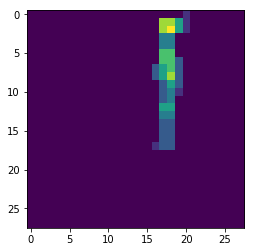

In [25]:
plt.imshow(oo3)
plt.show()

In [26]:
batch_img_path

array(['./MPII_Dataset/resize_images/005061084.jpg',
       './MPII_Dataset/resize_images/066283760.jpg',
       './MPII_Dataset/resize_images/087869758.jpg',
       './MPII_Dataset/resize_images/003419545.jpg',
       './MPII_Dataset/resize_images/055563476.jpg',
       './MPII_Dataset/resize_images/090801855.jpg',
       './MPII_Dataset/resize_images/054997899.jpg',
       './MPII_Dataset/resize_images/034762780.jpg',
       './MPII_Dataset/resize_images/053133995.jpg',
       './MPII_Dataset/resize_images/049174685.jpg',
       './MPII_Dataset/resize_images/020466895.jpg',
       './MPII_Dataset/resize_images/060051686.jpg',
       './MPII_Dataset/resize_images/056831915.jpg',
       './MPII_Dataset/resize_images/071408702.jpg',
       './MPII_Dataset/resize_images/077851429.jpg',
       './MPII_Dataset/resize_images/064136682.jpg',
       './MPII_Dataset/resize_images/039309772.jpg',
       './MPII_Dataset/resize_images/035853268.jpg',
       './MPII_Dataset/resize_images/033482785

In [6]:
batch_img, batch_img_path, batch_annotation, heatmap, \
stage_output1, stage_output2, stage_output3, stage_output4, stage_output5, stage_output6 = obj.test()

session start
INFO:tensorflow:Restoring parameters from C:/Users/JAEKYU/Documents/Jupyter Notebook/Open_Pose/Weight/Weight.ckpt
load


In [10]:
np.shape(stage_output1)

(32, 28, 28, 17)

In [85]:
test_index = 15
_batch_size = 32

In [90]:
img_data = cv2.imshow('image', batch_img[test_index])
cv2.waitKey(0)
cv2.destroyAllWindows()

Stage Output을 transpose하여 526x526 사이즈로 resize 하는 부분

In [91]:
#stage output의 (32, 28, 28, 17)형태를 (32, 17, 28, 28)로 바꿈
transposed_output = np.transpose(stage_output1, [0, 3, 1, 2])
#for i in range(_batch_size):
#    for j in range(17):
#        for row in range(28):
#            for col in range(28):
#                if (transposed_output[i][j][row][col] < 0):
#                    transposed_output[i][j][row][col] = 0



resized_transposed_output = np.zeros((32, 17, 526, 526))
for i in range(_batch_size):
    for j in range(17):
        resized_transposed_output[i][j] = cv2.resize(transposed_output[i][j], (526, 526))

Heatmap 0~17을 하나로 합치는 부분

In [92]:
merged_ = np.zeros((32, 526, 526))

for i in range(_batch_size):
    for j in range(17):
        merged_[i] = merged_[i] + resized_transposed_output[i][j]

합친 heatmap을 imshow 하는 부분

In [93]:
img_data = cv2.imshow('image2', 5* merged_[test_index])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [94]:
merged_[test_index]

array([[2.47633227e-02, 2.47633227e-02, 2.47633227e-02, ...,
        1.70796929e+01, 1.70796929e+01, 1.70796929e+01],
       [2.47633227e-02, 2.47633227e-02, 2.47633227e-02, ...,
        1.70796929e+01, 1.70796929e+01, 1.70796929e+01],
       [2.47633227e-02, 2.47633227e-02, 2.47633227e-02, ...,
        1.70796929e+01, 1.70796929e+01, 1.70796929e+01],
       ...,
       [1.21876642e-02, 1.21876642e-02, 1.21876642e-02, ...,
        1.67548165e+01, 1.67548165e+01, 1.67548165e+01],
       [1.21876642e-02, 1.21876642e-02, 1.21876642e-02, ...,
        1.67548165e+01, 1.67548165e+01, 1.67548165e+01],
       [1.21876642e-02, 1.21876642e-02, 1.21876642e-02, ...,
        1.67548165e+01, 1.67548165e+01, 1.67548165e+01]])

heatmap label 출력 해보는 부분(검증용)

In [59]:
transposed_heatmap = np.transpose(heatmap, [0, 3, 1, 2])
resized_transposed_heatmap = np.zeros((32, 17, 526, 526))
for i in range(_batch_size):
    for j in range(17):
        resized_transposed_heatmap[i][j] = cv2.resize(transposed_heatmap[i][j], (526, 526))
merged_ = np.zeros((32, 526, 526))
for i in range(_batch_size):
    for j in range(17):
        merged_[i] = merged_[i] + resized_transposed_heatmap[i][j]

In [60]:
img_data = cv2.imshow('image2', merged_[test_index])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [99]:
joint_from = [9, 8, 8, 8,13,14,12,11,7,6,6,3,4,2,1]#17

In [100]:
np.shape(joint_to)

(15,)

pyplot으로 test_index 의 이미지 heatmap 다 출력해보기

In [ ]:
#stage output의 (32, 28, 28, 17)형태를 (32, 17, 28, 28)로 바꿈
transposed_output = np.transpose(stage_output, [0, 3, 1, 2])

resized_transposed_output = np.zeros((32, 17, 526, 526))
for j in range(_batch_size):
    for i in range(17):
        resized_transposed_output[j][i] = cv2.resize(transposed_output[j][i], (526, 526))
        
for idx in (17):
    plt.imshow(resized_transposed_output[test_index][idx])
    plt.show()

In [42]:
def load_data():
    path = "./MPII_Dataset/annotation/mpii_human_pose_v1_u12_3.json"
    f = open(path)
    s = f.readlines()

    file_name = []
    parts = []
    _joint_data = []


    img_path = "./MPII_Dataset/images/"
    img_path2 = "./MPII_Dataset/resize_images2/"
    file_path = []
    file_path2 = []

    for index, i in enumerate(s):

        file_name_index = i.find("file_name")
        is_train_index = i.find("is_train")
        file_name.append(i[file_name_index + 13 :is_train_index - 4])


        parts_index = i.find("parts")
        visibility_index = i.find("visibility")
        parts.append(i[parts_index + 8:visibility_index - 3])

        joint_data = []
        file_index, annotation_index = index, index
        if(parts[index] == "null"):
            joint_data.append("null")
            pass
        else:
            raw_data = ast.literal_eval(parts[annotation_index])
            joint_data.append(raw_data)

        _joint_data.append(joint_data)
        index = index + 1
    for i in file_name:
        file_path.append(img_path + i)
        file_path2.append(img_path2 + i)

    index2 = 0
    heatmap_height = 44
    heatmap_width = 44
    for j in file_path:
        img_data = cv2.imread(j)
        height = (np.shape(img_data)[0])
        width = (np.shape(img_data)[1])

        if(_joint_data[index2][0] == 'null'):
            #print(_joint_data[index2][0])
            pass
        else:
            array = _joint_data[index2][0].keys()
            for k in array:
                _joint_data[index2][0][k][0] = int(_joint_data[index2][0][k][0] / height * heatmap_height)
                _joint_data[index2][0][k][1] = int(_joint_data[index2][0][k][1] / width * heatmap_width)



        index2 = index2 + 1


    return file_path2, _joint_data

In [43]:
file_path, joint_data = load_data()

In [45]:
batch_img_path, batch_anno_data = make_batch(file_path, joint_data, batch_size = 8)
batch_img_data = path_to_image(batch_img_path, batch_size=8)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

batch 적용한 heatmap

In [38]:
def bubble_sort(L):
    for i in range(len(L)-1):
        for j in range(len(L)-1):
            if L[j] > L[j+1]:
                temp = L[j+1]
                L[j+1] = L[j]
                L[j] = temp

batch_size = 8
width = 44
height = 44
num_of_maps = 17
output = np.zeros((batch_size, width, height, num_of_maps))
for index, joint_data in enumerate(batch_anno_data):

    heatmap = np.zeros((width, height, num_of_maps), np.int16)#batch 일단 뺌

    for joints in joint_data:
        buffer = list(joints.items())
        key_buffer = joints.keys()

        for i in range(len(buffer)):
            buffer[i] = list(buffer[i])
            buffer[i][0] = int(buffer[i][0])
        bubble_sort(buffer)

        print(key_buffer)
        print(buffer)
        idx = 0
        for j in range(17):
            
            #print(j)
            if('%d' %j in key_buffer):
                center_x = buffer[idx][1][0]
                center_y = buffer[idx][1][1]
                #joint = buffer[idx][1]
                joint = [center_y, center_x]
                idx = idx + 1
                _put_heatmap_on_plane(heatmap, plane_idx = j, joint = joint, sigma = 0.3, height = height, \
                                      width = width, stride = 1)
            else:
                pass
        idx = 0
    heatmap[:, :, -1] = np.clip(1.0 - np.amax(heatmap, axis=2), 0.0, 1.0)
    output[index] = heatmap
        

NameError: name 'batch_anno_data' is not defined

In [207]:
np.shape(heatmap)
np.shape(output)

(16, 28, 28, 17)

./MPII_Dataset/resize_images/048013494.jpg


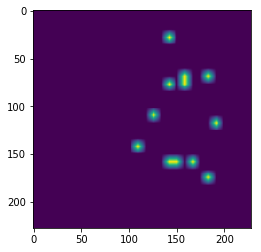

In [219]:
#for i in range(17):
test_index = 1
print(batch_img_path[test_index])
test_image = output[test_index]
test_image = np.transpose(test_image, (2,0,1))
#np.shape(test_image)
ooo = np.zeros((58, 58))
ooo2 = np.zeros((526, 526))
for i in range(16):
    ooo = ooo + test_image[i]
    #plt.imshow(test_image[i])
    #plt.show()
ooo2 = cv2.resize(ooo, (526, 526))
plt.imshow(ooo2)
plt.show()

batch 적용한 vectormap

In [197]:
batch_size = 32
output1 = np.zeros((batch_size, width, height, num_of_maps*2))
output2 = np.zeros((batch_size, width, height, num_of_maps))
for index, joint_data in enumerate(batch_anno_data):
    joint_pairs = list(zip(
        [9, 8, 8, 8,13,14,12,11,7,6,6,3,4,2,1],
        [8,13,12, 7,14,15,11,10,6,3,2,4,5,1,0]))
    #make vector map
    width = 58
    height = 58
    num_of_maps = 17
    vectormap = np.zeros((width, height, num_of_maps*2), dtype=np.float32)#batch 일단 뺌
    countmap = np.zeros((width, height, num_of_maps), np.int16)#batch 일단 뺌

    for joints in joint_data:
        key = (joints.keys())
        for plane_idx, (j_idx1, j_idx2) in enumerate(joint_pairs):
            if(('%d' %j_idx1 in key) and ('%d' %j_idx2 in key)):

                center_from = joints['%d'%j_idx1]
                center_to = joints['%d'%j_idx2]

                if not center_from or not center_to:
                    continue
                _put_paf_on_plane(vectormap=vectormap, countmap=countmap, plane_idx=plane_idx, center_from=center_from, center_to=center_to, \
                                  threshold=1, height=58, width=58, stride = 1)

    nonzeros = np.nonzero(countmap)


    for x, y, p in zip(nonzeros[0], nonzeros[1], nonzeros[2]):
        if countmap[x][y][p] <= 0:
            continue
        vectormap[x][y][p*2+0] /= countmap[x][y][p]
        vectormap[x][y][p*2+1] /= countmap[x][y][p]

    output1[index] = vectormap.astype(np.float32)
    output2[index] = countmap

(32, 28, 28, 17)


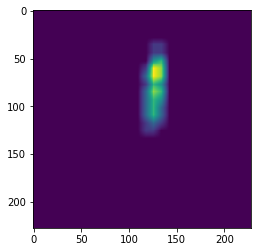

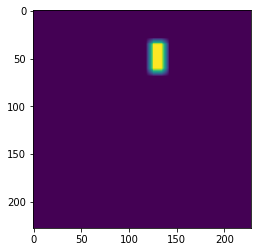

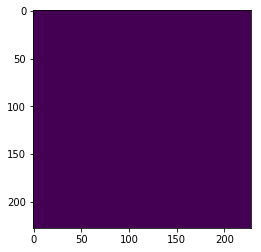

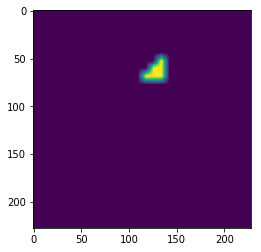

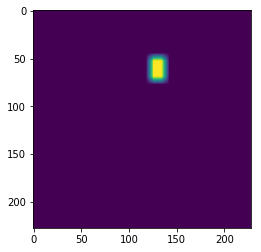

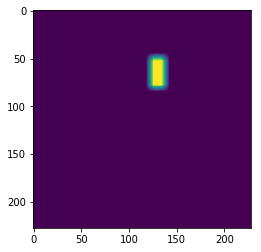

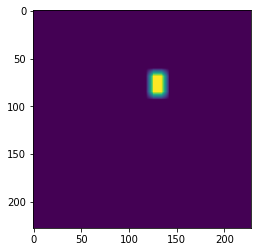

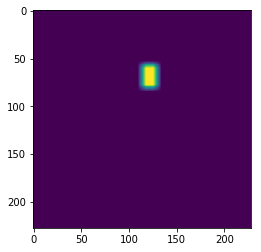

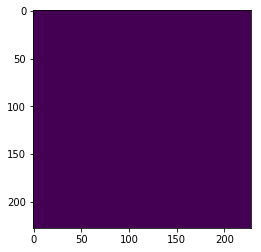

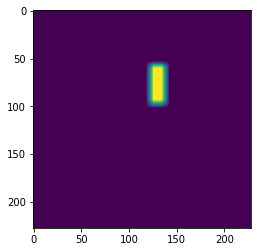

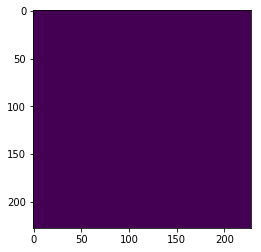

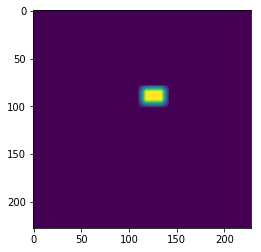

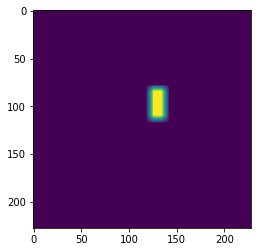

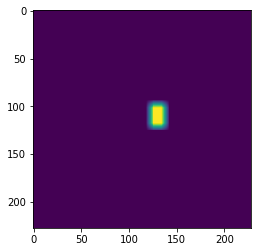

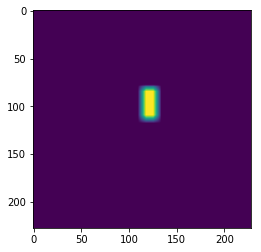

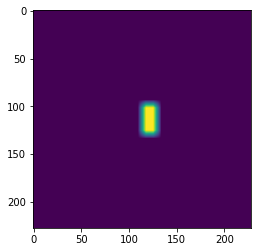

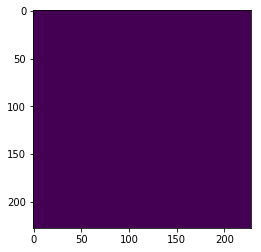

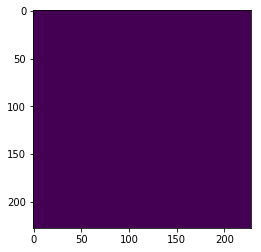

In [185]:
print(np.shape(output2))
transposed_countmap = np.transpose(output2[3], [2, 0, 1])
resized_countmap = np.zeros((17, 526, 526), dtype=np.float32)
summed_countmap = np.zeros((526, 526), dtype=np.float32)
for i in range(17):
    resized_countmap[i] = cv2.resize(transposed_countmap[i], (526, 526))
for j in range(17):
    summed_countmap = summed_countmap + resized_countmap[j]

plt.imshow(summed_countmap)
plt.show()

for i in range(17):
    plt.imshow(resized_countmap[i])
    plt.show()

plt.imshow(resized_countmap[i])
plt.show()